# SMYLE & CLM5-TRENDY GPP perfect prediction skill
- SMYLE global maps code updated for CLM output 
- Here comparing SMYLE GPP with TRENDY initial condions 
- Will Wieder, Oct 9, 2021

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from distributed import wait

%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [89]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
cluster

### Read in CLM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)

In [6]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [7]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [8]:
# SMYLE-NOV TWS data
# process all 20 ensemble members, all start dates dates from 1970-2018:
# these only need to be defined once, with io for each initialized month handled below
field = 'GPP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
print(filetemplate)
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
chunk = {}

/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.????-MM.EEE/lnd/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.????-MM.EEE.clm2.h0.GPP.*.nc


In [9]:
%%time
startmonth = 11
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('smyle11 data set = '+str(smyle11.nbytes/1e9)+ ' GB') #GB

smyle11 data set = 5.202259752 GB
CPU times: user 46.7 s, sys: 22.1 s, total: 1min 8s
Wall time: 1min 42s


In [10]:
%%time
# convert monthly data to seasonal data
smyle11 = cal.mon_to_seas_dask(smyle11).load()

CPU times: user 53.5 s, sys: 9.61 s, total: 1min 3s
Wall time: 1min 6s


In [11]:
%%time
# SMYLE-FEB TS data
# process all 20 ensemble members, Feb dates from 1970-2018:
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle02 data set = '+str(smyle02.nbytes/1e9)+ ' GB') #GB

smyle02 data set = 5.202259752 GB
CPU times: user 48.8 s, sys: 20.9 s, total: 1min 9s
Wall time: 1min 41s


In [12]:
%%time
# convert monthly data to seasonal data
smyle02 = cal.mon_to_seas_dask(smyle02).load()

CPU times: user 56 s, sys: 8.93 s, total: 1min 4s
Wall time: 1min 7s


In [13]:
%%time
# SMYLE-MAY TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('data set = '+str(smyle05.nbytes/1e9)+ ' GB') #GB

data set = 5.202259752 GB
CPU times: user 49.4 s, sys: 21 s, total: 1min 10s
Wall time: 1min 40s


In [14]:
%%time
# convert monthly data to seasonal data
smyle05 = cal.mon_to_seas_dask(smyle05).load()

CPU times: user 59.5 s, sys: 8.84 s, total: 1min 8s
Wall time: 1min 10s


In [15]:
%%time
# SMYLE-AUG TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle08 data set = '+str(smyle08.nbytes/1e9)+ ' GB') #GB

smyle08 data set = 5.202259752 GB
CPU times: user 48.8 s, sys: 20.5 s, total: 1min 9s
Wall time: 1min 37s


In [16]:
%%time
# convert monthly data to seasonal data
smyle08 = cal.mon_to_seas_dask(smyle08).load()

CPU times: user 1min, sys: 8.89 s, total: 1min 9s
Wall time: 1min 12s


### DataArrays are manageable size now (and in memory), so Dask cluster could be closed 

In [17]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11.to_netcdf(outdir+'SMYLE11_GPP_seas.nc')
smyle02.to_netcdf(outdir+'SMYLE02_GPP_seas.nc')
smyle05.to_netcdf(outdir+'SMYLE05_GPP_seas.nc')
smyle08.to_netcdf(outdir+'SMYLE08_GPP_seas.nc')

CPU times: user 243 ms, sys: 6.05 s, total: 6.29 s
Wall time: 7.93 s


In [ ]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11 = xr.open_dataset(outdir+'SMYLE11_GPP_seas.nc')
smyle02 = xr.open_dataset(outdir+'SMYLE02_GPP_seas.nc')
smyle05 = xr.open_dataset(outdir+'SMYLE05_GPP_seas.nc')
smyle08 = xr.open_dataset(outdir+'SMYLE08_GPP_seas.nc')

### Get results from CLM5 SMYLE-TRENDY for potential predictability
/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/

In [18]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.'+field+'.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
ds_clm['time']

<xarray.DataArray 'time' (time: 708)>
array([cftime.DatetimeNoLeap(1960, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00

### Compute OBS seasonal averages

In [19]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [20]:
clm_seas = obs_convert_mon_to_seas(ds_clm[field],field)

In [21]:
## convert OBS to anomalies from 1972-2017
clm_seas = clm_seas - clm_seas.sel(year=slice(1972,2018)).mean('year')

In [22]:
clm_seas = clm_seas.sel(year=slice(1960,2018))
clm_seas

<xarray.Dataset>
Dimensions:  (year: 59, lon: 288, lat: 192, season: 4)
Coordinates:
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017 2018
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    GPP      (season, year, lat, lon) float64 nan nan nan nan ... nan nan nan

# Anomaly Correlation Plots

In [23]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11.time,1972,2018)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02.time,1972,2018)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05.time,1972,2018)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08.time,1972,2018)

In [44]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_skill_byseas(mod_da,mod_time,obs_da,detrend=False):
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    e_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse})

In [42]:
%%time
smyle11_skill = leadtime_skill_byseas(smyle11_anom[field],smyle11.time,clm_seas[field])
smyle02_skill = leadtime_skill_byseas(smyle02_anom[field],smyle02.time,clm_seas[field])
smyle05_skill = leadtime_skill_byseas(smyle05_anom[field],smyle05.time,clm_seas[field])
smyle08_skill = leadtime_skill_byseas(smyle08_anom[field],smyle08.time,clm_seas[field])

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site

CPU times: user 19.7 s, sys: 13 s, total: 32.7 s
Wall time: 34.5 s


CPU times: user 14.1 s, sys: 286 ms, total: 14.3 s
Wall time: 14.7 s


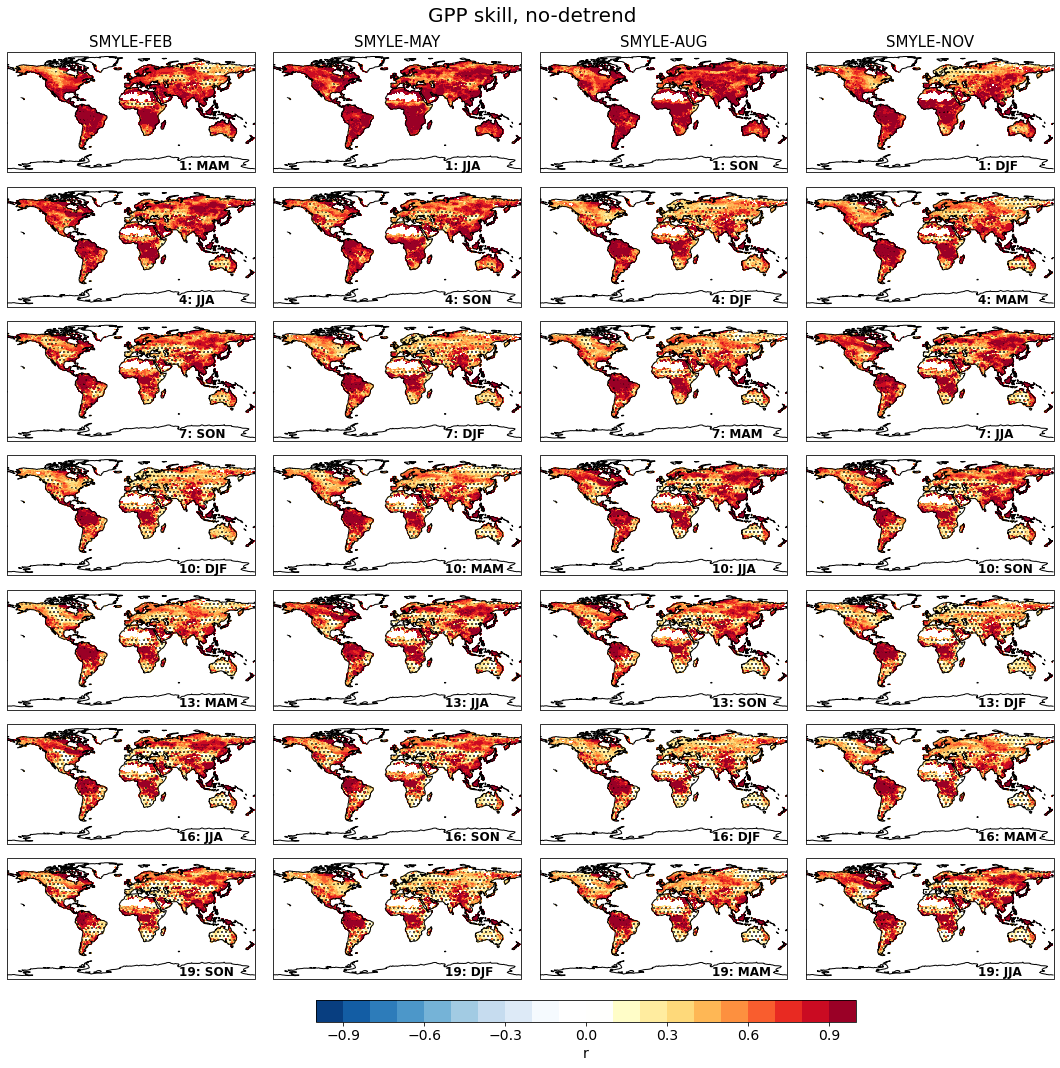

In [43]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(15,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj)
    ax1.contourf(smyle02_skill.lon, smyle02_skill.lat,smyle02_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj)
    ax2.contourf(smyle05_skill.lon, smyle05_skill.lat,smyle05_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj)
    ax3.contourf(smyle08_skill.lon, smyle08_skill.lat,smyle08_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj)
    ax4.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle((field+' skill, no-detrend'),fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal') ;

### Test Significance Hatching using correlation p-values

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 314 ms


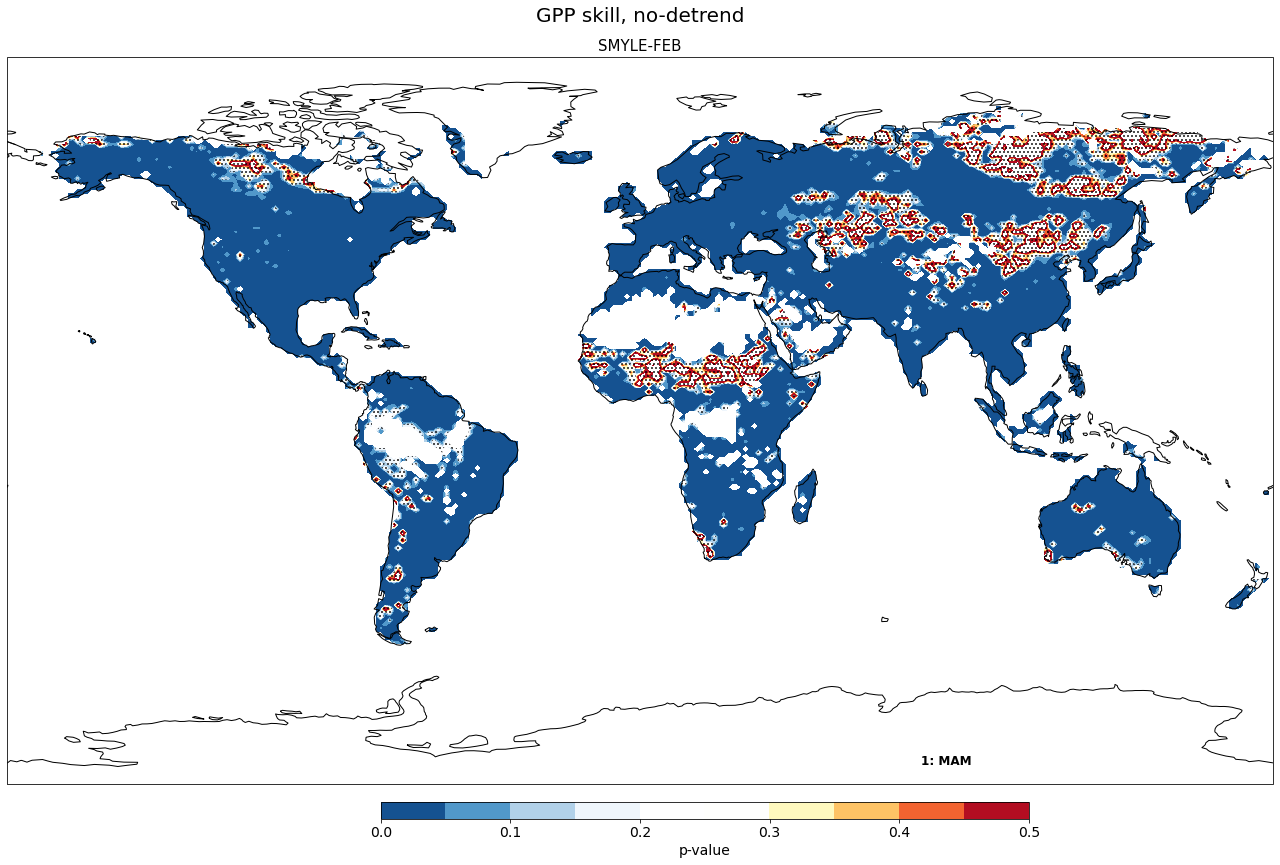

In [45]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,12))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*4+1,proj)
    ax1.contourf(smyle02_skill.lon, smyle02_skill.lat,smyle02_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle(field+' skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [64]:
%%time
smyle11_skill = leadtime_skill_byseas(smyle11_anom[field],smyle11.time,clm_seas[field],detrend=True)
smyle02_skill = leadtime_skill_byseas(smyle02_anom[field],smyle02.time,clm_seas[field],detrend=True)
smyle05_skill = leadtime_skill_byseas(smyle05_anom[field],smyle05.time,clm_seas[field],detrend=True)
smyle08_skill = leadtime_skill_byseas(smyle08_anom[field],smyle08.time,clm_seas[field],detrend=True)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site

CPU times: user 56.5 s, sys: 17.2 s, total: 1min 13s
Wall time: 1min 17s


CPU times: user 53.4 s, sys: 1.03 s, total: 54.5 s
Wall time: 57.4 s


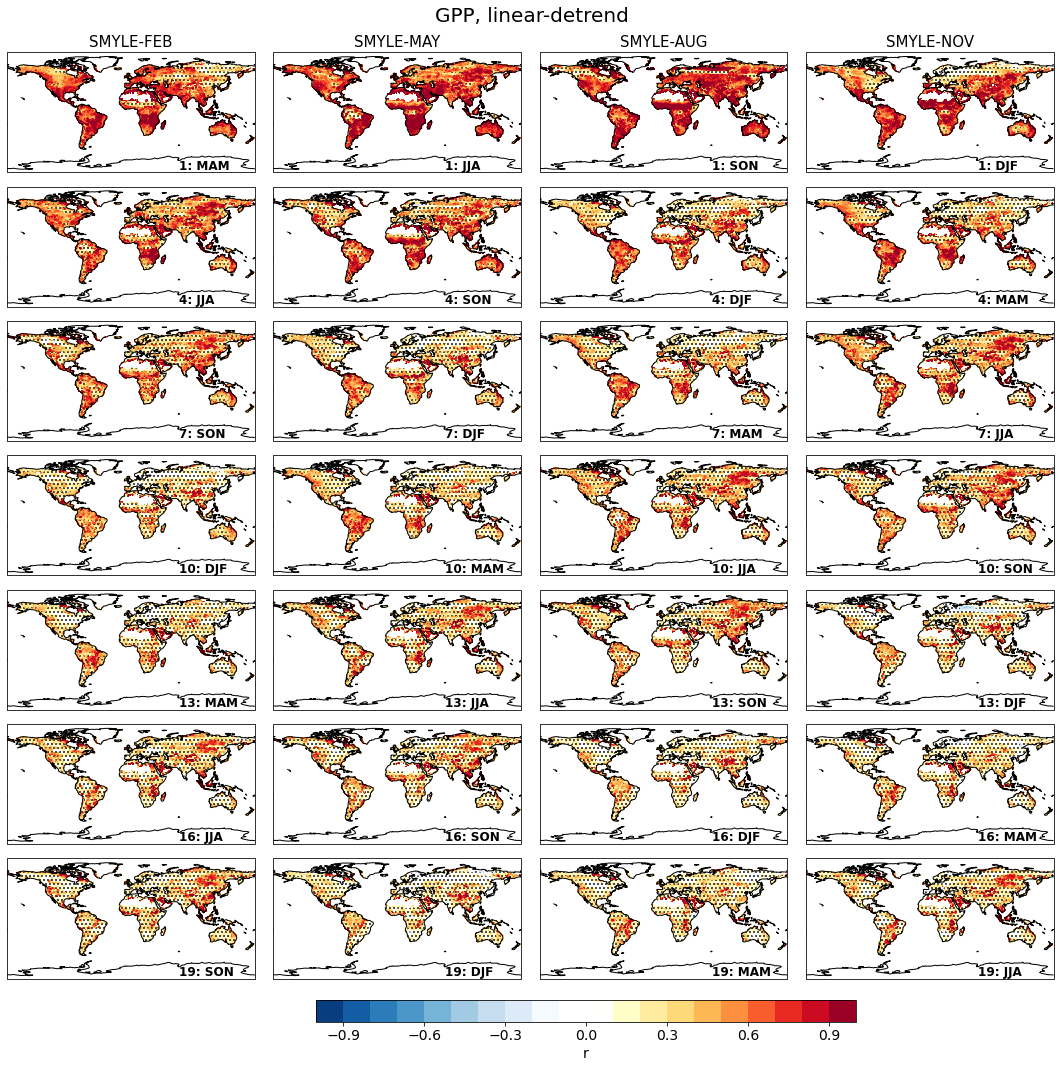

In [47]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(15,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj)
    ax1.contourf(smyle02_skill.lon, smyle02_skill.lat,smyle02_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj)
    ax2.contourf(smyle05_skill.lon, smyle05_skill.lat,smyle05_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj)
    ax3.contourf(smyle08_skill.lon, smyle08_skill.lat,smyle08_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj)
    ax4.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle(field+', linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
#plt.savefig('Fig_'+field+'.png')

## Deeper dive into high JJA skill over Siberia

CPU times: user 608 ms, sys: 13.9 ms, total: 622 ms
Wall time: 641 ms


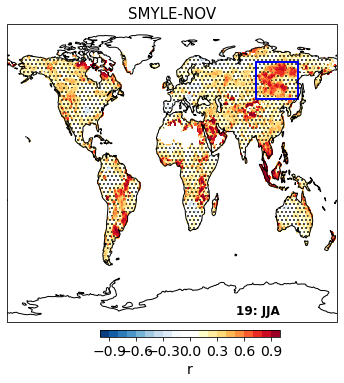

In [66]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(5,5))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,1,1,1,proj)
ax4.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=6), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
ax4.add_patch(mpatches.Rectangle(xy=[92, 45], width=45, height=22,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))

fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr4, cax=cbar_ax, label='r', orientation='horizontal')

In [67]:
# Siberia regional-average
region1lonlat = [92.,137.,45.,67.]  
region1title = 'Siberia'

tmp = clm_seas[field].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
trendy_gpp = tmp.weighted(wgts).mean(("lon", "lat"))

tmp = smyle11_anom.isel(L=6).mean('M').sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
smyle_gpp = tmp.weighted(wgts).mean(("lon", "lat")).rename({'Y':'time'})
smyle_gpp = smyle_gpp['GPP']
smyle_gpp['time'] = smyle11.isel(L=6).time.dt.year.values

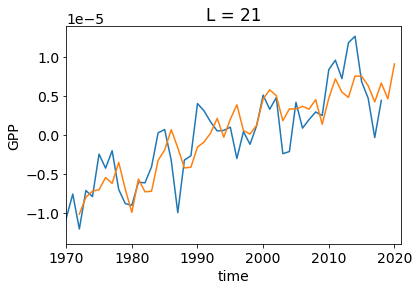

In [68]:
trendy_gpp.sel(season='JJA').plot(xlim=[1970,2021]);
smyle_gpp.plot()

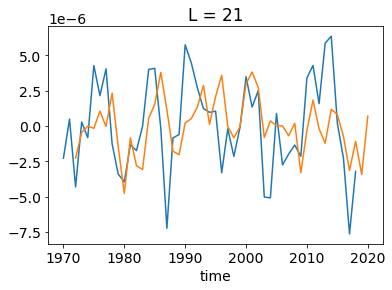

In [69]:
detrend_linear(trendy_gpp.sel(season='JJA').sel(year=slice(1970,2021)),'year').plot();
detrend_linear(smyle_gpp.sel(time=slice(1970,2021)),'time').plot();

In [70]:
%%time
smyle11_reg = smyle11_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle11_reg = smyle11_reg.weighted(wgts).mean(("lon", "lat"))
smyle02_reg = smyle02_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle02_reg = smyle02_reg.weighted(wgts).mean(("lon", "lat"))
smyle05_reg = smyle05_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle05_reg = smyle05_reg.weighted(wgts).mean(("lon", "lat"))
smyle08_reg = smyle08_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle08_reg = smyle08_reg.weighted(wgts).mean(("lon", "lat"))

CPU times: user 398 ms, sys: 119 ms, total: 516 ms
Wall time: 524 ms


In [71]:
%%time
smyle11_skill_reg = leadtime_skill_byseas(smyle11_reg[field],smyle11.time,trendy_gpp,detrend=True)
smyle02_skill_reg = leadtime_skill_byseas(smyle02_reg[field],smyle02.time,trendy_gpp,detrend=True)
smyle05_skill_reg = leadtime_skill_byseas(smyle05_reg[field],smyle05.time,trendy_gpp,detrend=True)
smyle08_skill_reg = leadtime_skill_byseas(smyle08_reg[field],smyle08.time,trendy_gpp,detrend=True)

CPU times: user 584 ms, sys: 13.9 ms, total: 598 ms
Wall time: 621 ms


(0.5, 1.5)

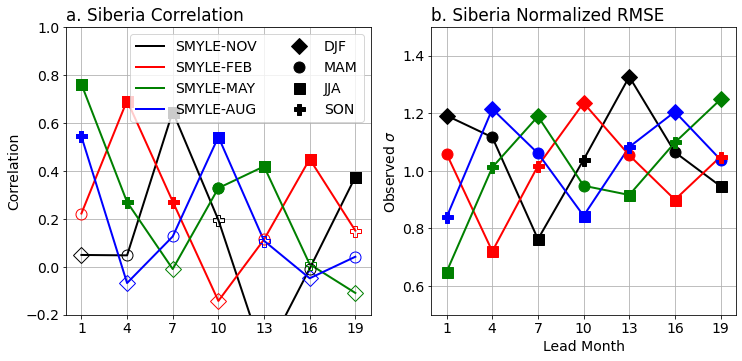

In [72]:
# plot correlation
fig = plt.figure(figsize=(12,18))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_reg.L-2
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
regiontitle = 'Siberia'

ncol = 2
nrow = 3

ax = fig.add_subplot(3,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_title('a. {} Correlation'.format(regiontitle),loc='left')
ax.plot(leadmon,smyle11_skill_reg.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_skill_reg.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_skill_reg.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_skill_reg.corr,color='b',linewidth=2,label='SMYLE-AUG')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season==i).where(smyle11_skill_reg.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season==i).where(smyle02_skill_reg.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season==i).where(smyle05_skill_reg.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season==i).where(smyle08_skill_reg.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='upper right',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([0,20])
ax.set_ylim([-0.2,1])

ax = fig.add_subplot(3,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. {} Normalized RMSE'.format(regiontitle),loc='left')
ax.plot(leadmon,smyle11_skill_reg.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_skill_reg.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_skill_reg.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_skill_reg.rmse,color='b',linewidth=2)
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_reg.rmse.where(smyle11_skill_reg.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill_reg.rmse.where(smyle02_skill_reg.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_reg.rmse.where(smyle05_skill_reg.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_reg.rmse.where(smyle08_skill_reg.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([0,20])
ax.set_ylim([0.5,1.5])

In [79]:
smyle11_reg

<xarray.Dataset>
Dimensions:  (L: 8, Y: 49, M: 20)
Coordinates:
  * L        (L) int64 3 6 9 12 15 18 21 24
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    GPP      (Y, L, M) float64 3.263e-08 -3.343e-08 -5.212e-08 ... nan nan nan

CPU times: user 1.8 s, sys: 138 ms, total: 1.94 s
Wall time: 2.03 s


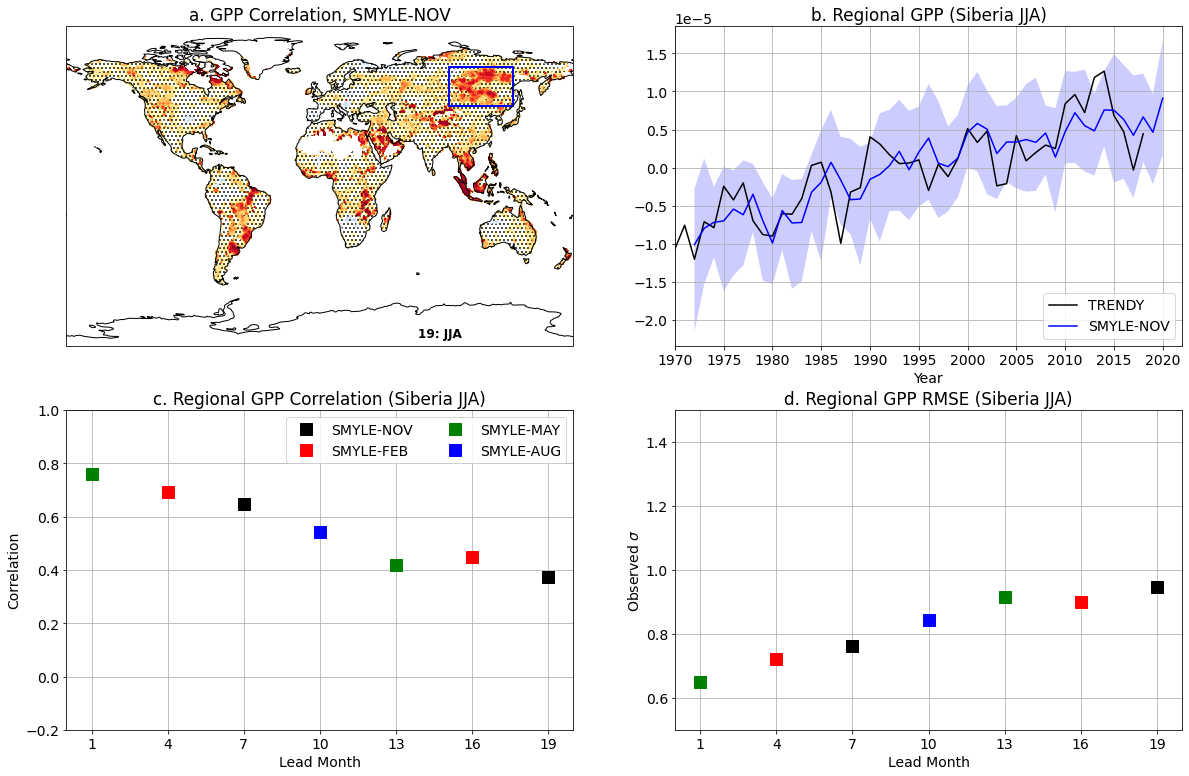

In [99]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(20,20))
nrows=2
ncols=2

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrow,ncol,1,proj)
ax1.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=6), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
ax1.add_patch(mpatches.Rectangle(xy=[92, 45], width=45, height=22,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))
ax1.set_title('a. GPP Correlation, SMYLE-NOV',loc='center')

ax2 = fig.add_subplot(nrow,ncol,2)
ax2.plot(trendy_gpp.year,trendy_gpp.sel(season='JJA'),color='k',label='TRENDY')
smyle11_time = smyle11.isel(L=6).time.dt.year.values
ax2.plot(smyle11_time,smyle11_reg['GPP'].mean('M').isel(L=6),color='b',label='SMYLE-NOV')
ymin = smyle11_reg['GPP'].min('M').isel(L=6)
ymax = smyle11_reg['GPP'].max('M').isel(L=6)
ax2.fill_between(smyle11_time,ymin,ymax,fc='b',alpha=0.2)
ax2.legend(loc='lower right')
ax2.set_xticks(np.arange(1970,2025,5))
ax2.grid(True)
ax2.set_xlim([1970,2022])
ax2.set_title('b. Regional GPP (Siberia JJA)',loc='center')
ax2.set_xlabel('Year')
#ax2.set_ylim([-0.2,1])

ax3 = fig.add_subplot(nrow,ncol,3)
leadmon = smyle11_skill_reg.L-2
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
ax3.set_ylabel('Correlation', fontsize=14)
ax3.set_title('c. Regional GPP Correlation (Siberia JJA)',loc='center')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA').where(smyle11_skill_reg.pval<0.1),color='k',marker='s',ms=12,label='SMYLE-NOV',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA').where(smyle02_skill_reg.pval<0.1),color='r',marker='s',ms=12,label='SMYLE-FEB',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA').where(smyle05_skill_reg.pval<0.1),color='g',marker='s',ms=12,label='SMYLE-MAY',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA').where(smyle08_skill_reg.pval<0.1),color='b',marker='s',ms=12,label='SMYLE-AUG',linestyle='none')
ax3.legend(loc='upper right',ncol=2)
ax3.set_xticks(leadmon)
ax3.grid(True)
ax3.set_xlim([0,20])
ax3.set_ylim([-0.2,1])
ax3.set_xlabel('Lead Month')

ax4 = fig.add_subplot(nrow,ncol,4)
ax4.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax4.set_title('d. Regional GPP RMSE (Siberia JJA)',loc='center')
ax4.plot(leadmon,smyle11_skill_reg.rmse.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle02_skill_reg.rmse.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle05_skill_reg.rmse.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle08_skill_reg.rmse.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',ms=12,linestyle='none')
ax4.set_xticks(leadmon)
ax4.grid(True)
ax4.set_xlim([0,20])
ax4.set_ylim([0.5,1.5])
ax4.set_xlabel('Lead Month')

plt.savefig('GPPskill_Siberia_JJA.png')